In [2]:
import yaml
import numpy as np
from TraceSimulator import LongTraceSimulator
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import fftconvolve


def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('/home/dwong/DELight_mtr/trigger_study/archive/wk11/config.yaml')
lts = LongTraceSimulator(config)


sampling_frequency = 3906250
vac_template = np.load("templates/vac_ch_template.npy")
template = np.load("templates/sub_ch_template.npy")
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")
length = len(template)

if length%2==0:
    noise_psd_unfolded = np.concatenate(([np.inf],
                                                noise_psd[1:-1]/2,
                                                [noise_psd[-1]],
                                                noise_psd[-2:0:-1]/2))
else:
    noise_psd_unfolded = np.concatenate(([np.inf],
                                                noise_psd[1:]/2,
                                                noise_psd[-1:0:-1]/2))
    
template_fft = fft(template)/sampling_frequency

kernel_fft = template_fft.conjugate() / noise_psd_unfolded
kernel_normalization = np.real(np.dot(kernel_fft, template_fft))*sampling_frequency/3276800
filter_kernel = kernel_fft / kernel_normalization
kernel_td = np.real(ifft(filter_kernel)) * sampling_frequency


In [3]:
trace, idx= lts.generate(
            E=70000,
            x=-94, y=0, z=-1800,
            no_noise=False,
            type_recoil='NR',
            quantize=True,
            phonon_only=False
        )
trace = trace[0]

715293
732444


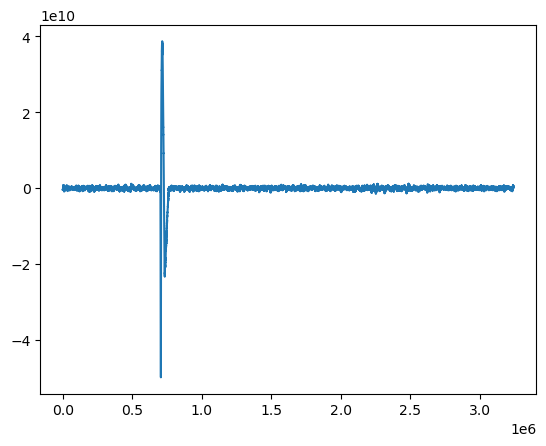

In [7]:
filtered_trace = fftconvolve(trace[7], kernel_td[::-1], mode='valid')
plt.plot(filtered_trace)
print(np.argmax(filtered_trace))
print(idx)

In [5]:
example = trace[7][idx:idx+32768]

allowed_shift_range=None

trace_fft = fft(example, axis=-1)/sampling_frequency # V
trace_filtered = filter_kernel * trace_fft
trace_filtered_td = np.real(
    ifft(trace_filtered, axis=-1)
) * sampling_frequency

chi0 = np.real((trace_fft.conj() * trace_fft / noise_psd_unfolded).sum()) * sampling_frequency / length
chit_withdelay = (trace_filtered_td ** 2) * kernel_normalization
chi = chi0 - chit_withdelay

if allowed_shift_range is None:
    ind = np.arange(len(chi))
else:
    ind = np.concatenate((np.arange(length+allowed_shift_range[0], length),
                            np.arange(allowed_shift_range[1]+1)))

best_ind = ind[np.argmin(chi[ind], axis=-1)]

amp = trace_filtered_td[best_ind]
chisq = chi[best_ind]/(length-3)
t0 = best_ind if best_ind<length//2 else best_ind-length
        


In [29]:
amp

227.84763616413446

In [7]:
example = trace[7]

In [36]:

idx

500276

In [12]:
kernel_normalization = np.real(np.dot(kernel_fft, template_fft)) * sampling_frequency / 3276800


In [8]:
def center_of_mass(template, use_abs=False):
    if use_abs:
        weights = np.abs(template)
    else:
        weights = template

    indices = np.arange(len(template))
    return np.sum(indices * weights) / np.sum(weights)
com = center_of_mass(template)

In [9]:
com

12239.352775760633

In [10]:
import numpy as np

x = np.array([1, 2, 3])
h = np.array([4, 5])
N = len(x) + len(h) - 1

# Time-domain convolution
y_time = np.convolve(x, h)

# Frequency-domain convolution
x_padded = np.pad(x, (0, N - len(x)))
h_padded = np.pad(h, (0, N - len(h)))
y_fft = np.fft.ifft(np.fft.fft(x_padded) * np.fft.fft(h_padded)).real

print(np.allclose(y_time, y_fft))  # ✅ True


True
